In [35]:
import pandas as pd
import numpy as np
managers_with_birth = pd.read_csv('managers_with_birth.csv')
managers_with_birth

,Name,Seasons,Games,Team,Wiki_Names,Birth_Year
0,Scott Servais,2016–,1194,SEA,Scott Servais,1967
1,Lloyd McClendon,2014–2015,324,SEA,Lloyd McClendon,1959
2,Eric Wedge,2011–2013,486,SEA,Eric Wedge,1968
3,Daren Brown,2010,50,SEA,Daren Brown,1967
4,Don Wakamatsu,2009–2010,274,SEA,Don Wakamatsu,1963
...,...,...,...,...,...,...
220,Ryne Sandberg,2013–2015,278,PHI,Ryne Sandberg,1959
221,Charlie Manuel,2005–2013,1416,PHI,Charlie Manuel,1944
222,Gary Varsho,2004,2,PHI,Gary Varsho,1961
223,Larry Bowa,2001–2004,645,PHI,Larry Bowa,1945


In [2]:
managers_with_birth = managers_with_birth.drop(columns= ['Wiki_Names'])

In [3]:
def add_ending_year(time_range):
    '''Adds an ending year of 2024 to managers who are currently managing (end with -).'''
    fixed_range = time_range.replace('present', '').replace('Present', '') # Get rid of possible '-present' at end
    fixed_range = fixed_range.replace('–', '-').strip() # Use the standard dash instead of Wikipedia's weird dash, and get rid of extranneous spaces
    if (fixed_range[-1] == '-'):
        fixed_range += '2024'
    return fixed_range
managers_with_birth = managers_with_birth.assign(Seasons = managers_with_birth.get('Seasons').apply(add_ending_year))

In [4]:
def get_years_coached(seasons_info):
    '''Returns a dictionary containing all the years and the games of a coach'''
    try:
        start_year, end_year = seasons_info.split('-')
    except ValueError: # Coached only one year
        return [int(seasons_info)] # Return only year as a list
    if (start_year == end_year):
        return [int(start_year)]
    start_year = int(start_year)
    end_year = int(end_year)
    seasons_list = []
    for year in range(start_year, end_year + 1): # Include both start and end points
        seasons_list = seasons_list + [year]
    return seasons_list
managers_with_birth = managers_with_birth.assign(Years_Coached = managers_with_birth.get('Seasons').apply(get_years_coached))
managers_with_birth

,Name,Seasons,Games,Team,Birth_Year,Years_Coached
0,Scott Servais,2016-2024,1194,SEA,1967,"[2016, 2017, 2018, 2019, 2020, 2021, 2022, 202..."
1,Lloyd McClendon,2014-2015,324,SEA,1959,"[2014, 2015]"
2,Eric Wedge,2011-2013,486,SEA,1968,"[2011, 2012, 2013]"
3,Daren Brown,2010,50,SEA,1967,[2010]
4,Don Wakamatsu,2009-2010,274,SEA,1963,"[2009, 2010]"
...,...,...,...,...,...,...
220,Ryne Sandberg,2013-2015,278,PHI,1959,"[2013, 2014, 2015]"
221,Charlie Manuel,2005-2013,1416,PHI,1944,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201..."
222,Gary Varsho,2004,2,PHI,1961,[2004]
223,Larry Bowa,2001-2004,645,PHI,1945,"[2001, 2002, 2003, 2004]"


In [5]:
def contains_after_2008(list):
    '''True if the list contains any values after 2008'''
    if max(list) >= 2008:
        return True
    return False

def contains_only_2024(list):
    if (min(list) == 2024):
        return True
    return False

# Remove all managers who did not coach since 2008, since 2008 is the cutoff I plan to use.
since_2008 = managers_with_birth[(managers_with_birth.get('Years_Coached')).apply(contains_after_2008)]
since_2008 = since_2008[since_2008.get('Years_Coached').apply(contains_only_2024) == False]
since_2008

,Name,Seasons,Games,Team,Birth_Year,Years_Coached
0,Scott Servais,2016-2024,1194,SEA,1967,"[2016, 2017, 2018, 2019, 2020, 2021, 2022, 202..."
1,Lloyd McClendon,2014-2015,324,SEA,1959,"[2014, 2015]"
2,Eric Wedge,2011-2013,486,SEA,1968,"[2011, 2012, 2013]"
3,Daren Brown,2010,50,SEA,1967,[2010]
4,Don Wakamatsu,2009-2010,274,SEA,1963,"[2009, 2010]"
...,...,...,...,...,...,...
214,Manny Acta,2007-2009,410,WAS,1969,"[2007, 2008, 2009]"
218,Gabe Kapler,2018-2019,324,PHI,1975,"[2018, 2019]"
219,Pete Mackanin,2015-2017,412,PHI,1951,"[2015, 2016, 2017]"
220,Ryne Sandberg,2013-2015,278,PHI,1959,"[2013, 2014, 2015]"


We still have a problem: We can see that there are multiple managers with the same name, but there are years where multiple managers coached the same team. For instance, Manager A coached Team A for the first 90 games, and Manager B coached Team A for the remaining 72 games after manager A was fired. We still need to categorize which ejection came at what time. Let's see these instances (where more than one coach coached a team)

In [6]:
from collections import Counter

duplicates = []
for one_team in since_2008.get('Team').unique():
    all_years_managed = np.array([], dtype = int)
    team_df = since_2008[since_2008.get('Team') == one_team]
    for i in range(len(team_df)):
        all_years_managed = np.append(all_years_managed, team_df.iloc[i].get('Years_Coached'))
    years_count = Counter(all_years_managed)
    duplicates.extend([(one_team, element, count) for element, count in years_count.items() if count > 1])
duplicates[0:9] # List of all sets of interim managers

[('SEA', 2010, 2),
 ('SEA', 2008, 2),
 ('OAK', 2011, 2),
 ('TEX', 2022, 2),
 ('TEX', 2018, 2),
 ('TEX', 2014, 2),
 ('HOU', 2014, 2),
 ('HOU', 2012, 2),
 ('HOU', 2009, 2)]

In [7]:
recent_intentional_hbps = pd.read_csv('intentional_hbps.csv')

In [8]:
recent_intentional_hbps = recent_intentional_hbps.drop(columns = ['Unnamed: 0'])
recent_intentional_hbps

,DATE,TEAM,REASON,YEAR
0,05/20/2008,NYA,Throwing at batter,2008
1,06/13/2008,SLN,Intentional HBP,2008
2,07/19/2008,TOR,Intentional HBP,2008
3,07/29/2008,BAL,Intentional HBP,2008
4,07/30/2008,NYA,Throwing at batter,2008
...,...,...,...,...
117,05/18/2021,MIN,Throwing at batter,2021
118,04/08/2022,WAS,Intentionally hitting batter,2022
119,04/09/2022,CHN,Intentionally hitting batter,2022
120,05/10/2022,TOR,Intentionally hitting batter,2022


The team names of this dataframe do not align with managers_with_birth. Let's fix these manually by using retrosheet's team abbreviations: https://www.retrosheet.org/TEAMABR.TXT.

In [9]:
recent_intentional_hbps = recent_intentional_hbps.rename(columns = {"TEAM": "Team", "REASON": "Reason", "YEAR": "Year", "DATE": "Date"})
recent_intentional_hbps

,Date,Team,Reason,Year
0,05/20/2008,NYA,Throwing at batter,2008
1,06/13/2008,SLN,Intentional HBP,2008
2,07/19/2008,TOR,Intentional HBP,2008
3,07/29/2008,BAL,Intentional HBP,2008
4,07/30/2008,NYA,Throwing at batter,2008
...,...,...,...,...
117,05/18/2021,MIN,Throwing at batter,2021
118,04/08/2022,WAS,Intentionally hitting batter,2022
119,04/09/2022,CHN,Intentionally hitting batter,2022
120,05/10/2022,TOR,Intentionally hitting batter,2022


In [10]:
np.sort(recent_intentional_hbps.get('Team').unique())

array(['ANA', 'ARI', 'ATL', 'BAL', 'BOS', 'CHA', 'CHN', 'CIN', 'CLE',
       'COL', 'DET', 'FLO', 'HOU', 'KCA', 'LAN', 'MIA', 'MIL', 'MIN',
       'NYA', 'NYN', 'OAK', 'PHI', 'PIT', 'SDN', 'SEA', 'SFN', 'SLN',
       'TBA', 'TEX', 'TOR', 'WAS'], dtype=object)

In [11]:
np.sort(since_2008.get('Team').unique())

array(['ARI', 'ATL', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL',
       'DET', 'HOU', 'KCN', 'LAA', 'LAN', 'MIA', 'MIL', 'MIN', 'NYM',
       'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SEA', 'SFN', 'STL', 'TAM',
       'TEX', 'TOR', 'WAS'], dtype=object)

In [12]:
def rename_teams(retro_team):
    teams_dict = {
        'ANA': 'LAA','ARI': 'ARI','ATL': 'ATL','BAL': 'BAL','BOS': 'BOS','CHA': 'CHW','CHN': 'CHC','CIN': 'CIN','CLE': 'CLE',
        'COL': 'COL', 'DET': 'DET', 'FLO': 'MIA', 'HOU': 'HOU', 'KCA': 'KCN', 'LAN': 'LAN', 'MIA': 'MIA', 'MIL': 'MIL', 'MIN': 'MIN', 'NYA': 'NYY',
        'NYN': 'NYM', 'OAK': 'OAK', 'PHI': 'PHI', 'PIT': 'PIT', 'SDN': 'SDP', 'SEA': 'SEA', 'SFN': 'SFN', 'SLN': 'STL', 'TBA': 'TAM',
        'TEX': 'TEX', 'TOR': 'TOR', 'WAS': 'WAS'
                  }
    return teams_dict[retro_team]
recent_intentional_hbps = recent_intentional_hbps.assign(Team = recent_intentional_hbps.get('Team').apply(rename_teams))
recent_intentional_hbps

,Date,Team,Reason,Year
0,05/20/2008,NYY,Throwing at batter,2008
1,06/13/2008,STL,Intentional HBP,2008
2,07/19/2008,TOR,Intentional HBP,2008
3,07/29/2008,BAL,Intentional HBP,2008
4,07/30/2008,NYY,Throwing at batter,2008
...,...,...,...,...
117,05/18/2021,MIN,Throwing at batter,2021
118,04/08/2022,WAS,Intentionally hitting batter,2022
119,04/09/2022,CHC,Intentionally hitting batter,2022
120,05/10/2022,TOR,Intentionally hitting batter,2022


In [13]:
duplicates

[('SEA', 2010, 2),
 ('SEA', 2008, 2),
 ('OAK', 2011, 2),
 ('TEX', 2022, 2),
 ('TEX', 2018, 2),
 ('TEX', 2014, 2),
 ('HOU', 2014, 2),
 ('HOU', 2012, 2),
 ('HOU', 2009, 2),
 ('LAA', 2022, 2),
 ('CLE', 2012, 2),
 ('CHW', 2011, 2),
 ('KCN', 2010, 2),
 ('DET', 2020, 2),
 ('TOR', 2022, 2),
 ('TOR', 2008, 2),
 ('BAL', 2010, 3),
 ('SFN', 2023, 2),
 ('SDP', 2019, 2),
 ('SDP', 2015, 3),
 ('COL', 2009, 2),
 ('ARI', 2014, 2),
 ('ARI', 2010, 2),
 ('ARI', 2009, 2),
 ('CIN', 2018, 2),
 ('CHC', 2010, 2),
 ('MIL', 2015, 2),
 ('MIL', 2008, 2),
 ('STL', 2018, 2),
 ('ATL', 2016, 2),
 ('MIA', 2015, 2),
 ('MIA', 2011, 3),
 ('MIA', 2010, 2),
 ('NYM', 2008, 2),
 ('WAS', 2011, 3),
 ('WAS', 2009, 2),
 ('PHI', 2015, 2),
 ('PHI', 2013, 2)]

In [14]:
def check_team_year_exists(df, team_chosen, year_chosen):
    '''True if df contains a value with the selected team at the selected year'''
    if df[(df.get('Team') == team_chosen) & (df.get('Year') == year_chosen)].shape[0] > 0:
        return True
    return False

potential_errors = []
# Check if a duplicate corresponds with a team
for duplicate in duplicates:
    team_name = duplicate[0]
    year_name = duplicate[1]
    if (check_team_year_exists(recent_intentional_hbps, team_name, year_name)):
        potential_errors = potential_errors + [(team_name, year_name)]
potential_errors

[('HOU', 2014),
 ('CLE', 2012),
 ('TOR', 2022),
 ('TOR', 2008),
 ('BAL', 2010),
 ('ARI', 2014),
 ('MIL', 2008),
 ('ATL', 2016),
 ('MIA', 2015),
 ('MIA', 2011),
 ('MIA', 2010),
 ('WAS', 2011),
 ('PHI', 2015)]

Now that we know the potential errors, let's get ready to combine the dataframes. 

First, Let's rename the Date column for clarity in the merged dataframe

In [15]:
recent_intentional_hbps = recent_intentional_hbps.rename(columns = {'Date': 'Ejection_Date', 'Year': 'Ejection_Year'}).drop(columns = ['Reason'])

In [16]:
managers_with_birth = managers_with_birth.drop(columns = ['Games', 'Seasons'])
managers_with_birth

,Name,Team,Birth_Year,Years_Coached
0,Scott Servais,SEA,1967,"[2016, 2017, 2018, 2019, 2020, 2021, 2022, 202..."
1,Lloyd McClendon,SEA,1959,"[2014, 2015]"
2,Eric Wedge,SEA,1968,"[2011, 2012, 2013]"
3,Daren Brown,SEA,1967,[2010]
4,Don Wakamatsu,SEA,1963,"[2009, 2010]"
...,...,...,...,...
220,Ryne Sandberg,PHI,1959,"[2013, 2014, 2015]"
221,Charlie Manuel,PHI,1944,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201..."
222,Gary Varsho,PHI,1961,[2004]
223,Larry Bowa,PHI,1945,"[2001, 2002, 2003, 2004]"


I merged it managers_with_birth with recent_intentional_hbps. It would have been smarter to do since_2008, but it will not end up making a difference, because my later program would get rid of extra lines.

In [17]:
combined_df = managers_with_birth.merge(recent_intentional_hbps, on = 'Team')
combined_df

,Name,Team,Birth_Year,Years_Coached,Ejection_Date,Ejection_Year
0,Scott Servais,SEA,1967,"[2016, 2017, 2018, 2019, 2020, 2021, 2022, 202...",08/31/2016,2016
1,Lloyd McClendon,SEA,1959,"[2014, 2015]",08/31/2016,2016
2,Eric Wedge,SEA,1968,"[2011, 2012, 2013]",08/31/2016,2016
3,Daren Brown,SEA,1967,[2010],08/31/2016,2016
4,Don Wakamatsu,SEA,1963,"[2009, 2010]",08/31/2016,2016
...,...,...,...,...,...,...
920,Larry Bowa,PHI,1945,"[2001, 2002, 2003, 2004]",07/16/2019,2019
921,Terry Francona,PHI,1959,"[1997, 1998, 1999, 2000]",06/13/2014,2014
922,Terry Francona,PHI,1959,"[1997, 1998, 1999, 2000]",06/16/2015,2015
923,Terry Francona,PHI,1959,"[1997, 1998, 1999, 2000]",07/15/2019,2019


Let's get rid of all the rows where ejection_year is not in years_coached, because then the manager was not a part of the ejection

In [18]:
combined_df = combined_df[combined_df.apply(lambda row: row.get('Ejection_Year') in row.get('Years_Coached'), axis = 1)]
combined_df

,Name,Team,Birth_Year,Years_Coached,Ejection_Date,Ejection_Year
0,Scott Servais,SEA,1967,"[2016, 2017, 2018, 2019, 2020, 2021, 2022, 202...",08/31/2016,2016
12,Bob Melvin,OAK,1961,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",09/18/2012,2012
13,Bob Melvin,OAK,1961,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",06/08/2014,2014
25,Chris Woodward,TEX,1976,"[2019, 2020, 2021, 2022]",07/27/2019,2019
28,Jeff Banister,TEX,1965,"[2015, 2016, 2017, 2018]",04/05/2016,2016
...,...,...,...,...,...,...
899,Gabe Kapler,PHI,1975,"[2018, 2019]",07/15/2019,2019
900,Gabe Kapler,PHI,1975,"[2018, 2019]",07/16/2019,2019
902,Pete Mackanin,PHI,1951,"[2015, 2016, 2017]",06/16/2015,2015
905,Ryne Sandberg,PHI,1959,"[2013, 2014, 2015]",06/13/2014,2014


In [19]:
combined_df.groupby(['Ejection_Date', 'Team']).count().sort_values(by = 'Name', ascending = False)

,,Name,Birth_Year,Years_Coached,Ejection_Year
Ejection_Date,Team,,,,
09/26/2010,BAL,3,3,3,3
06/05/2011,WAS,3,3,3,3
04/10/2011,MIA,3,3,3,3
05/10/2022,TOR,2,2,2,2
09/01/2010,MIA,2,2,2,2
...,...,...,...,...,...
06/05/2010,WAS,1,1,1,1
06/01/2013,BAL,1,1,1,1
05/30/2014,BOS,1,1,1,1


Let's manually fix the issues that we have, where multiple managers correspond to one ejection, even though only one should.

In [20]:
potential_errors

[('HOU', 2014),
 ('CLE', 2012),
 ('TOR', 2022),
 ('TOR', 2008),
 ('BAL', 2010),
 ('ARI', 2014),
 ('MIL', 2008),
 ('ATL', 2016),
 ('MIA', 2015),
 ('MIA', 2011),
 ('MIA', 2010),
 ('WAS', 2011),
 ('PHI', 2015)]

In [21]:
def get_team_year(df, team_chosen, year_chosen):
    '''True if df contains a value with the selected team at the selected year'''
    return df[(df.get('Team') == team_chosen) & (df.get('Ejection_Year') == year_chosen)]

for team_name, year_name in potential_errors:
    print(get_team_year(combined_df, team_name, year_name))

           Name Team  Birth_Year Years_Coached Ejection_Date  Ejection_Year
53  Tom Lawless  HOU        1956        [2014]    04/24/2014           2014
57    Bo Porter  HOU        1972  [2013, 2014]    04/24/2014           2014
                 Name Team  Birth_Year       Years_Coached Ejection_Date  \
120  Sandy Alomar Jr.  CLE        1966              [2012]    04/14/2012   
126        Manny Acta  CLE        1969  [2010, 2011, 2012]    04/14/2012   

     Ejection_Year  
120           2012  
126           2012  
                Name Team  Birth_Year             Years_Coached Ejection_Date  \
327   John Schneider  TOR        1980        [2022, 2023, 2024]    05/10/2022   
333  Charlie Montoyo  TOR        1965  [2019, 2020, 2021, 2022]    05/10/2022   

     Ejection_Year  
327           2022  
333           2022  
             Name Team  Birth_Year                   Years_Coached  \
346   Cito Gaston  TOR        1944              [2008, 2009, 2010]   
352  John Gibbons  TOR        196

In [22]:
wrong_values = [53, 120, 327, 352, 393, 401, 510, 511, 626, 698, 756, 735, 739, 745, 850, 857, 902]
# These are the years / manager combinations that are incorrect and should be removed from the dataframe, from manually looking at the data
combined_df = combined_df.drop(wrong_values)
combined_df

,Name,Team,Birth_Year,Years_Coached,Ejection_Date,Ejection_Year
0,Scott Servais,SEA,1967,"[2016, 2017, 2018, 2019, 2020, 2021, 2022, 202...",08/31/2016,2016
12,Bob Melvin,OAK,1961,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",09/18/2012,2012
13,Bob Melvin,OAK,1961,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",06/08/2014,2014
25,Chris Woodward,TEX,1976,"[2019, 2020, 2021, 2022]",07/27/2019,2019
28,Jeff Banister,TEX,1965,"[2015, 2016, 2017, 2018]",04/05/2016,2016
...,...,...,...,...,...,...
864,Jim Riggleman,WAS,1952,"[2009, 2010, 2011]",06/05/2011,2011
899,Gabe Kapler,PHI,1975,"[2018, 2019]",07/15/2019,2019
900,Gabe Kapler,PHI,1975,"[2018, 2019]",07/16/2019,2019
905,Ryne Sandberg,PHI,1959,"[2013, 2014, 2015]",06/13/2014,2014


In [23]:
(combined_df.groupby(['Ejection_Date', 'Team']).count().rename(columns = {'Name': 'Count'})
 .get(['Count']).sort_values(by = 'Count', ascending = False)) # Make sure that there are no ejections getting double-counted


,,Count
Ejection_Date,Team,
03/31/2019,ATL,1
08/23/2012,MIN,1
08/15/2018,MIA,1
08/13/2016,COL,1
08/13/2008,ATL,1
...,...,...
05/30/2014,BOS,1
05/30/2012,CHW,1
05/29/2019,KCN,1


Perfect, no team / date combination occurs multiple times, meaning that the same ejection is not getting counted for multiple managers.

In [24]:
combined_df = combined_df.assign(Manager_Age = combined_df.apply(lambda row: row.get('Ejection_Year') - row.get('Birth_Year'), axis = 1))
combined_df

,Name,Team,Birth_Year,Years_Coached,Ejection_Date,Ejection_Year,Manager_Age
0,Scott Servais,SEA,1967,"[2016, 2017, 2018, 2019, 2020, 2021, 2022, 202...",08/31/2016,2016,49
12,Bob Melvin,OAK,1961,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",09/18/2012,2012,51
13,Bob Melvin,OAK,1961,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",06/08/2014,2014,53
25,Chris Woodward,TEX,1976,"[2019, 2020, 2021, 2022]",07/27/2019,2019,43
28,Jeff Banister,TEX,1965,"[2015, 2016, 2017, 2018]",04/05/2016,2016,51
...,...,...,...,...,...,...,...
864,Jim Riggleman,WAS,1952,"[2009, 2010, 2011]",06/05/2011,2011,59
899,Gabe Kapler,PHI,1975,"[2018, 2019]",07/15/2019,2019,44
900,Gabe Kapler,PHI,1975,"[2018, 2019]",07/16/2019,2019,44
905,Ryne Sandberg,PHI,1959,"[2013, 2014, 2015]",06/13/2014,2014,55


Perfect, now we're ready to get the average manager age, when they coached a pitcher who intentionally hit a batter.

In [25]:
combined_df.get('Manager_Age').mean()

54.295081967213115

Let's get a good comparison for the baseline age. Let's take the weighted average of all ages for managers, and compare it to the current. One way we can do this is by including only years since 2008, computing a manager's age at every year, and then taking a weighted average of the years (weighted such that managers who coached more games have a greater weight -- we're more likely to see them in an average game).

In [26]:
since_2008

,Name,Seasons,Games,Team,Birth_Year,Years_Coached
0,Scott Servais,2016-2024,1194,SEA,1967,"[2016, 2017, 2018, 2019, 2020, 2021, 2022, 202..."
1,Lloyd McClendon,2014-2015,324,SEA,1959,"[2014, 2015]"
2,Eric Wedge,2011-2013,486,SEA,1968,"[2011, 2012, 2013]"
3,Daren Brown,2010,50,SEA,1967,[2010]
4,Don Wakamatsu,2009-2010,274,SEA,1963,"[2009, 2010]"
...,...,...,...,...,...,...
214,Manny Acta,2007-2009,410,WAS,1969,"[2007, 2008, 2009]"
218,Gabe Kapler,2018-2019,324,PHI,1975,"[2018, 2019]"
219,Pete Mackanin,2015-2017,412,PHI,1951,"[2015, 2016, 2017]"
220,Ryne Sandberg,2013-2015,278,PHI,1959,"[2013, 2014, 2015]"


In [27]:
def get_earliest_year(years_coached_list):
    return years_coached_list[0]

since_2008[since_2008.get('Years_Coached').apply(get_earliest_year) <= 2007]

,Name,Seasons,Games,Team,Birth_Year,Years_Coached
6,John McLaren,2007-2008,156,SEA,1951,"[2007, 2008]"
12,Bob Geren,2007-2011,710,OAK,1961,"[2007, 2008, 2009, 2010, 2011]"
21,Ron Washington,2007-2014,1275,TEX,1952,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]"
33,Cecil Cooper,2007-2009,341,HOU,1949,"[2007, 2008, 2009]"
40,Mike Scioscia,2000-2018,3078,LAA,1958,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200..."
45,Eric Wedge,2003-2009,1134,CLE,1968,"[2003, 2004, 2005, 2006, 2007, 2008, 2009]"
53,Ozzie Guillén,2004-2011,1295,CHW,1964,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]"
68,Jim Leyland,2006-2013,1297,DET,1944,"[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]"
74,Ron Gardenhire,2002-2014,2107,MIN,1957,"[2002, 2003, 2004, 2005, 2006, 2007, 2008, 200..."
84,Terry Francona,2004-2011,1296,BOS,1959,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]"


Let's get the actual games coached within the interval of the manager. The easiest (and most accurate) way to do this is by manually resolving the issues.

In [28]:
def set_games(pos, games):
    since_2008.get('Games').loc[pos] = games

set_games(6, 72)
since_2008.get('Games').loc[12] = 710 - 162
since_2008.get('Games').loc[21] = 1275 - 162
since_2008.get('Games').loc[33] = 341 - 15 - 16
set_games(40, 3078 - 162 * 8)
set_games(45, 1134 - 162 * 5)
set_games(53, 1295 - 162 * 4)
set_games(68, 1297 - 162 * 2)
set_games(74, 1297 - 162 * 6)
set_games(84, 1296 - 162 * 4)
set_games(93, 74)
set_games(100, 470 - 93)
set_games(105, 470 - 162 * 2)
set_games(112, 2106 - 162)
set_games(128, 1362 - 163)
set_games(133, 1159 - 162 * 6 + 22)
set_games(140, 677 - 162 * 3)
set_games(159, 609 - 162)
set_games(168, 959 - 162 * 5 + 35)
set_games(174, 2591 - 162 * 12 + 2)
set_games(184, 3269 - 162 * 14 - 97 - 114 - 144 - 160)
set_games(193, 555 - 162)
set_games(205, 555 - 162 * 3)
set_games(214, 410 - 162)
set_games(221, 1416 - 162 * 3)


/var/folders/xv/svgwynh921zf62sfypxdy8w00000gq/T/ipykernel_19015/2871547120.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  since_2008.get('Games').loc[12] = 710 - 162
/var/folders/xv/svgwynh921zf62sfypxdy8w00000gq/T/ipykernel_19015/2871547120.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  since_2008.get('Games').loc[21] = 1275 - 162
/var/folders/xv/svgwynh921zf62sfypxdy8w00000gq/T/ipykernel_19015/2871547120.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [29]:
def remove_before_2007(years_list):
    '''Remove years before 2007, since these were excluded from games'''
    return [year for year in years_list if year >= 2008]

since_2008 = since_2008.assign(Years_Coached = since_2008.get('Years_Coached').apply(remove_before_2007))
since_2008

,Name,Seasons,Games,Team,Birth_Year,Years_Coached
0,Scott Servais,2016-2024,1194,SEA,1967,"[2016, 2017, 2018, 2019, 2020, 2021, 2022, 202..."
1,Lloyd McClendon,2014-2015,324,SEA,1959,"[2014, 2015]"
2,Eric Wedge,2011-2013,486,SEA,1968,"[2011, 2012, 2013]"
3,Daren Brown,2010,50,SEA,1967,[2010]
4,Don Wakamatsu,2009-2010,274,SEA,1963,"[2009, 2010]"
...,...,...,...,...,...,...
214,Manny Acta,2007-2009,248,WAS,1969,"[2008, 2009]"
218,Gabe Kapler,2018-2019,324,PHI,1975,"[2018, 2019]"
219,Pete Mackanin,2015-2017,412,PHI,1951,"[2015, 2016, 2017]"
220,Ryne Sandberg,2013-2015,278,PHI,1959,"[2013, 2014, 2015]"


Let's see a distribution of the true games coached within this timeframe

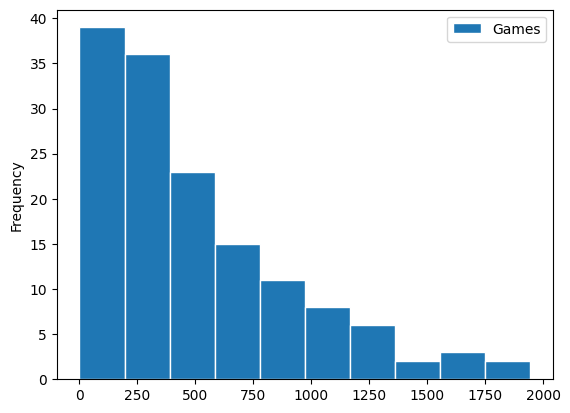

In [30]:
since_2008.plot(kind = 'hist', ec = 'w', y = 'Games');

In [31]:
since_2008 = since_2008.assign(Average_Age = since_2008.apply(lambda row: np.median(row.get('Years_Coached')) - row.get('Birth_Year'), axis = 1))
since_2008


,Name,Seasons,Games,Team,Birth_Year,Years_Coached,Average_Age
0,Scott Servais,2016-2024,1194,SEA,1967,"[2016, 2017, 2018, 2019, 2020, 2021, 2022, 202...",53.0
1,Lloyd McClendon,2014-2015,324,SEA,1959,"[2014, 2015]",55.5
2,Eric Wedge,2011-2013,486,SEA,1968,"[2011, 2012, 2013]",44.0
3,Daren Brown,2010,50,SEA,1967,[2010],43.0
4,Don Wakamatsu,2009-2010,274,SEA,1963,"[2009, 2010]",46.5
...,...,...,...,...,...,...,...
214,Manny Acta,2007-2009,248,WAS,1969,"[2008, 2009]",39.5
218,Gabe Kapler,2018-2019,324,PHI,1975,"[2018, 2019]",43.5
219,Pete Mackanin,2015-2017,412,PHI,1951,"[2015, 2016, 2017]",65.0
220,Ryne Sandberg,2013-2015,278,PHI,1959,"[2013, 2014, 2015]",55.0


Now, we're ready to compute the average age of a manager, by taking a weighted mean of their age and their games coached. This way, managers who coached more games will have their ages weighted more, as it should be.

In [32]:
def compute_weighted_mean_ages():
    numerator = since_2008.apply(lambda row: row.get('Games') * row.get('Average_Age'), axis = 1).sum()
    denominator = since_2008.get('Games').sum()
    return numerator/denominator
mean_age_population = compute_weighted_mean_ages()
mean_age_population

54.12591177732564

In [33]:
age_sample = combined_df.get('Manager_Age')
print(age_sample.mean(), age_sample.std())

54.295081967213115 7.886266464782713


In [34]:
from scipy.stats import norm
sample_sd = age_sample.std()/np.sqrt(age_sample.shape[0])
z = norm.ppf(0.9)
left = age_sample.mean() - z * sample_sd
right = age_sample.mean() + z * sample_sd
(left, right) 

(53.38006822356838, 55.21009571085785)

We fail to reject the null hypothesis, and thus do not conclude that manager ages correlate with pitcher ejections.